In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [2]:
model = load_model("models/modellov6_rumori.h5")

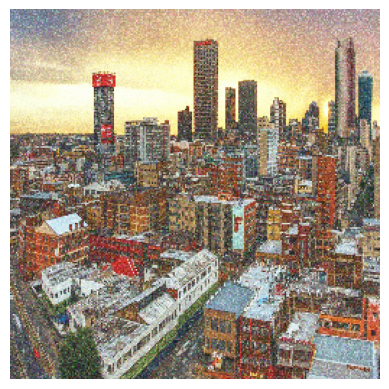

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

img_path = 'johan_con_rumore_esponenziale.jpg'
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)  # Decodifica l'immagine in RGB
resized_img = tf.image.resize(img, (256, 256))
preprocessed_image = resized_img / 255.0

# Visualizza l'immagine
plt.imshow(preprocessed_image)  # Normalizza i valori dei pixel tra 0 e 1
plt.axis('off')  # Nasconde gli assi
plt.show()

In [14]:
import cv2
import matplotlib.pyplot as plt

img_noise_path = 'guate_con_rumore_nonuniforme.jpg'
img_path = 'guate.jpg'

# Leggo l'immagine con OpenCV
image_read = cv2.imread(img_path)
image_noise_read = cv2.imread(img_noise_path)

# Ridimensiona l'immagine
resized_image = cv2.resize(image_noise_read, (256, 256))
resized_image = resized_image/255

cv2.imshow('Immagine Originale', image_read)
cv2.imshow('Immagine Rumorosa', resized_image)  
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
prediction = model.predict(np.expand_dims(resized_image, axis=0))

1/1 [==============================] - 0s 327ms/step


In [8]:
prediction

array([[9.99673605e-01, 1.09719374e-04, 2.73886235e-05, 1.88952312e-04,
        4.08554200e-07]], dtype=float32)

In [16]:
class_labels = ['rumore_esponenziale', 'rumore_gaussiano', 'rumore_non_uniforme', 'rumore_sale_e_pepe', 'rumore_uniforme']  # Lista delle classi di rumore
predicted_class_index = np.argmax(prediction)   # Restituisce la classe con probabilità più alta
predicted_class_label = class_labels[predicted_class_index]

In [17]:
predicted_class_label

'rumore_non_uniforme'

deviazione standard rumorosa stimata: 0.1497435446415737
PSNR Noisy, originale vs filtrata con mediano:  16.66336590720096
PSNR Noisy, originale vs filtrata NLM Veloce:  16.011280944898154
PSNR Noisy, originale vs filtrata visu:  15.892400515390214
PSNR Noisy, originale vs filtrata Bregman:  16.047953645082803
PSNR Noisy, originale vs filtrata BM3D:  16.14616536961602


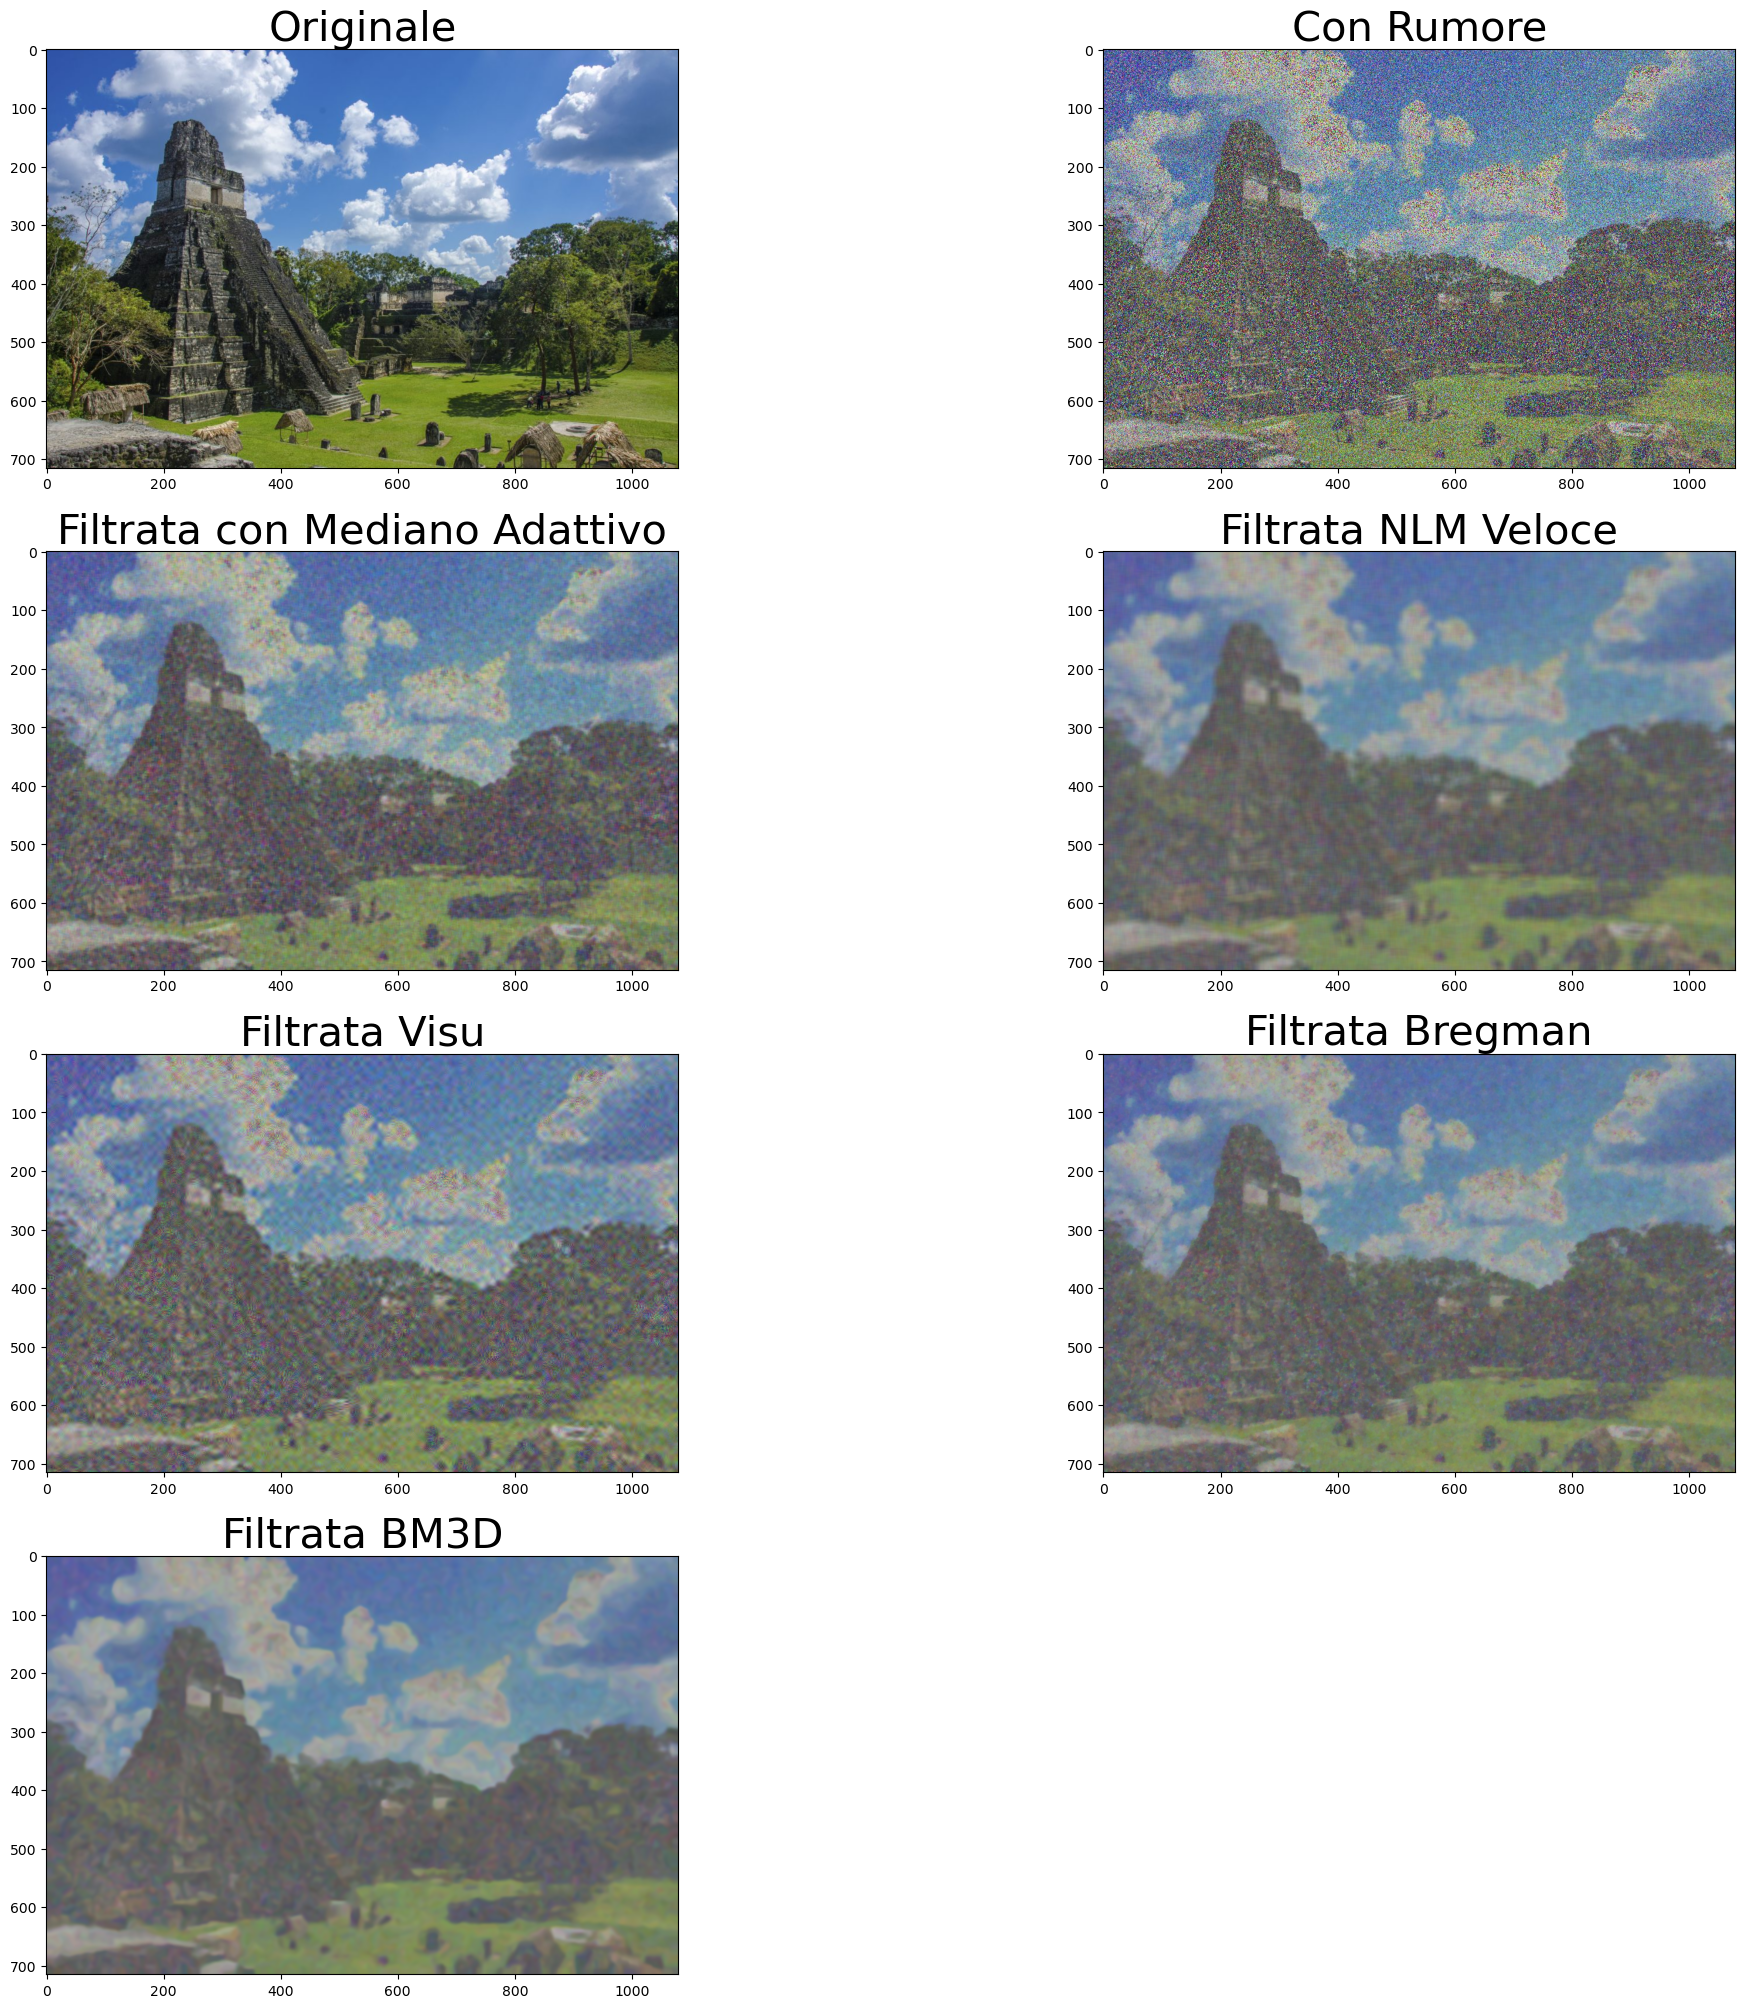

In [18]:
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_wavelet, estimate_sigma, denoise_nl_means, denoise_tv_bregman, denoise_bilateral)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from scipy.linalg import svd
from scipy.ndimage import (gaussian_filter, median_filter, generic_filter)
import bm3d
import skimage.io
import cv2

if predicted_class_label == 'rumore_sale_e_pepe':  # Funziona molto bene

    image_rgb = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    img=skimage.img_as_float(image_rgb)
    image_noise_rgb = cv2.cvtColor(image_noise_read, cv2.COLOR_BGR2RGB)
    imgn=skimage.img_as_float(image_noise_rgb)

    # multichannel: calcola la deviazione std per ogni canale RGB e ne fa la media
    sigma_est=estimate_sigma(imgn, average_sigmas=True, channel_axis=2)  # Stima la deviazione standard dall'immagine rumorosa

    img_bayes=denoise_wavelet(imgn, method='BayesShrink', mode='soft', 
                              wavelet_levels=3, wavelet='db20',
                             convert2ycbcr=True, rescale_sigma=True, channel_axis=2)  #23.40 con levels03 e coif5
    #25.33 con db20

    img_visushrink=denoise_wavelet(imgn, method='VisuShrink', mode='soft', sigma=sigma_est/2,
                                   wavelet_levels=3, wavelet='db20',  convert2ycbcr=False, 
                                   rescale_sigma=True, channel_axis=2)   # con db20 25.43 PSNR
    
    sigma_est_nl = np.mean(estimate_sigma(imgn, channel_axis=-1))
    print(f'deviazione standard rumorosa stimata: {sigma_est_nl}')
    
    patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=-1)
    
    # Algoritmo lento
    img_filtrata_con_nl_lento = denoise_nl_means(imgn, h=1.15 * sigma_est_nl, fast_mode=False,
                                                 **patch_kw)
    # Algoritmo lento con deviazione standard
    img_filtrata_con_nl_sigma = denoise_nl_means(imgn, h=0.8 * sigma_est_nl, fast_mode=False,
                                                **patch_kw)
    # Algoritmo veloce
    img_filtrata_con_nl_veloce = denoise_nl_means(imgn, h=0.8 * sigma_est_nl, fast_mode=True,
                                                 **patch_kw)
    # Algoritmo veloce con sigma
    img_filtrata_con_nl_veloce_sigma = denoise_nl_means(imgn, h=0.6 * sigma_est_nl, sigma=sigma_est_nl,
                                                       fast_mode=True, **patch_kw)

    psnr_noisy = peak_signal_noise_ratio(img, imgn)
    psnr_bayes = peak_signal_noise_ratio(img, img_bayes)
    psnr_visu = peak_signal_noise_ratio(img, img_visushrink)
    psnr_nl_lento = peak_signal_noise_ratio(img, img_filtrata_con_nl_lento)
    psnr_nl_lento_sigma = peak_signal_noise_ratio(img, img_filtrata_con_nl_sigma)
    psnr_nl_veloce = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce)
    psnr_nl_veloce_sigma = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce_sigma)

    img_visushrink = skimage.img_as_float(img_visushrink) 
    img_visushrink = np.clip(img_visushrink, 0, 1)

    img_bayes = skimage.img_as_float(img_bayes) 
    img_bayes = np.clip(img_bayes, 0, 1)

    plt.figure(figsize=(30, 30))

    plt.subplot(4,2,1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title('Originale', fontsize=30)

    plt.subplot(4,2,2)
    plt.imshow(imgn, cmap=plt.cm.gray)
    plt.title('Con Rumore', fontsize=30)

    plt.subplot(4,2,3)
    plt.imshow(img_bayes, cmap=plt.cm.gray)
    plt.title('Filtrata Bayes', fontsize=30)

    plt.subplot(4,2,4)
    plt.imshow(img_visushrink, cmap=plt.cm.gray)
    plt.title('Filtrata Visu', fontsize=30)
    
    plt.subplot(4,2,5)
    plt.imshow(img_filtrata_con_nl_lento, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Lento', fontsize=30)
    
    plt.subplot(4,2,6)
    plt.imshow(img_filtrata_con_nl_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Lento & Sigma', fontsize=30)
    
    plt.subplot(4,2,7)
    plt.imshow(img_filtrata_con_nl_veloce, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Veloce', fontsize=30)
    
    plt.subplot(4,2,8)
    plt.imshow(img_filtrata_con_nl_veloce_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Veloce & Sigma', fontsize=30)

    print('PSNR Noisy, originale vs rumorosa: ', psnr_noisy)
    print('PSNR Noisy, originale vs filtrata bayes: ', psnr_bayes)
    print('PSNR Noisy, originale vs filtrata visu: ', psnr_visu)
    print('PSNR Noisy, originale vs filtrata NL Lento: ', psnr_nl_lento)
    print('PSNR Noisy, originale vs filtrata NL Lento & Sigma: ', psnr_nl_lento_sigma)
    print('PSNR Noisy, originale vs filtrata NL Veloce: ', psnr_nl_veloce)
    print('PSNR Noisy, originale vs filtrata NL Veloce & Sigma: ', psnr_nl_veloce_sigma)
    
    img_bayes_uint8 = skimage.util.img_as_ubyte(img_bayes)
    skimage.io.imsave('img_bayes_filtered.png', img_bayes_uint8)   # Funziona
    
    img_visu_uint8 = skimage.util.img_as_ubyte(img_visushrink)
    skimage.io.imsave('img_visu_filtered.png', img_visu_uint8)
    
elif predicted_class_label == 'rumore_gaussiano':  # Funziona molto bene

    image_rgb = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    img=skimage.img_as_float(image_rgb)
    image_noise_rgb = cv2.cvtColor(image_noise_read, cv2.COLOR_BGR2RGB)
    imgn=skimage.img_as_float(image_noise_rgb)
    
    img_filtrata_con_BM3D = bm3d.bm3d(imgn, sigma_psd=0.1, stage_arg=bm3d.BM3DStages.ALL_STAGES)  
    
    sigma_est_nl = np.mean(estimate_sigma(imgn, channel_axis=-1))
    print(f'deviazione standard rumorosa stimata: {sigma_est_nl}')
    
    patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=-1)
    
    # Algoritmo lento
    img_filtrata_con_nl_lento = denoise_nl_means(imgn, h=1.15 * sigma_est_nl, fast_mode=False,
                                                 **patch_kw)
    # Algoritmo lento con deviazione standard
    img_filtrata_con_nl_sigma = denoise_nl_means(imgn, h=0.8 * sigma_est_nl, fast_mode=False,
                                                **patch_kw)
    # Algoritmo veloce
    img_filtrata_con_nl_veloce = denoise_nl_means(imgn, h=0.8 * sigma_est_nl, fast_mode=True,
                                                 **patch_kw)
    # Algoritmo veloce con sigma
    img_filtrata_con_nl_veloce_sigma = denoise_nl_means(imgn, h=0.6 * sigma_est_nl, sigma=sigma_est_nl,
                                                       fast_mode=True, **patch_kw)
  
    img_filtrata_con_BM3D = skimage.img_as_float(img_filtrata_con_BM3D) 
    img_filtrata_con_BM3D = np.clip(img_filtrata_con_BM3D, 0, 1)
    
    psnr_noisy = peak_signal_noise_ratio(img, imgn)
    psnr_bm3d = peak_signal_noise_ratio(img, img_filtrata_con_BM3D)
    psnr_nl_lento = peak_signal_noise_ratio(img, img_filtrata_con_nl_lento)
    psnr_nl_lento_sigma = peak_signal_noise_ratio(img, img_filtrata_con_nl_sigma)
    psnr_nl_veloce = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce)
    psnr_nl_veloce_sigma = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce_sigma)

    plt.figure(figsize=(25, 25))

    plt.subplot(4,2,1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title('Originale', fontsize=30)

    plt.subplot(4,2,2)
    plt.imshow(imgn, cmap=plt.cm.gray)
    plt.title('Con Rumore', fontsize=30)

    plt.subplot(4,2,3)
    plt.imshow(img_filtrata_con_BM3D, cmap=plt.cm.gray)
    plt.title('Filtrata con BM3D', fontsize=30)
    
    plt.subplot(4,2,4)
    plt.imshow(img_filtrata_con_nl_lento, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Lento', fontsize=30)
    
    plt.subplot(4,2,5)
    plt.imshow(img_filtrata_con_nl_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Lento & Sigma', fontsize=30)
    
    plt.subplot(4,2,6)
    plt.imshow(img_filtrata_con_nl_veloce, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Veloce', fontsize=30)
    
    plt.subplot(4,2,7)
    plt.imshow(img_filtrata_con_nl_veloce_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Veloce & Sigma', fontsize=30)

    plt.delaxes(plt.subplot(4, 2, 8))

    print('PSNR Noisy, originale vs rumorosa: ', psnr_noisy)
    print('PSNR Noisy, originale vs filtrata bm3d: ', psnr_bm3d)
    print('PSNR Noisy, originale vs filtrata NL Lento: ', psnr_nl_lento)
    print('PSNR Noisy, originale vs filtrata NL Lento & Sigma: ', psnr_nl_lento_sigma)
    print('PSNR Noisy, originale vs filtrata NL Veloce: ', psnr_nl_veloce)
    print('PSNR Noisy, originale vs filtrata NL Veloce & Sigma: ', psnr_nl_veloce_sigma) 
    
    img_filtrata_con_nl_veloce_sigma_unit8 = skimage.util.img_as_ubyte(img_filtrata_con_nl_veloce_sigma)
    skimage.io.imsave('img_filtrata_con_nl_veloce_sigma.png', img_filtrata_con_nl_veloce_sigma_unit8)
    
    img_filtrata_con_BM3D_uint8 = skimage.util.img_as_ubyte(img_filtrata_con_BM3D)
    skimage.io.imsave('img_filtrata_con_BM3D.png', img_filtrata_con_BM3D_uint8)
    
elif predicted_class_label == 'rumore_esponenziale':   # Funziona ma con scarsi risultati
    
    image_rgb = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    img=skimage.img_as_float(image_rgb)
    image_noise_rgb = cv2.cvtColor(image_noise_read, cv2.COLOR_BGR2RGB)
    imgn=skimage.img_as_float(image_noise_rgb)
        
    sigma_est = np.mean(estimate_sigma(imgn, channel_axis=-1))
    print(f'deviazione standard rumorosa stimata: {sigma_est}')
    
    patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=-1)
    
    # Algoritmo lento
    img_filtrata_con_nl_lento = denoise_nl_means(imgn, h=1.30 * sigma_est, fast_mode=False,
                                                 **patch_kw)
    # Algoritmo lento con deviazione standard
    img_filtrata_con_nl_sigma = denoise_nl_means(imgn, h=0.8 * sigma_est, fast_mode=False,
                                                **patch_kw)
    # Algoritmo veloce
    img_filtrata_con_nl_veloce = denoise_nl_means(imgn, h=0.8 * sigma_est, fast_mode=True,
                                                 **patch_kw)
    # Algoritmo veloce con sigma
    img_filtrata_con_nl_veloce_sigma = denoise_nl_means(imgn, h=0.6 * sigma_est, sigma=sigma_est,
                                                       fast_mode=True, **patch_kw)
    
    img_filtrata_con_BM3D = bm3d.bm3d(imgn, sigma_psd=0.6, stage_arg=bm3d.BM3DStages.ALL_STAGES) 
    
    img_filtrata_con_BM3D = skimage.img_as_float(img_filtrata_con_BM3D) 
    img_filtrata_con_BM3D = np.clip(img_filtrata_con_BM3D, 0, 1)
     
    psnr_noisy = peak_signal_noise_ratio(img, imgn)
    psnr_bm3d = peak_signal_noise_ratio(img, imgn)
    psnr_nl_lento = peak_signal_noise_ratio(img, img_filtrata_con_nl_lento)
    psnr_nl_lento_sigma = peak_signal_noise_ratio(img, img_filtrata_con_nl_sigma)
    psnr_nl_veloce = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce)
    psnr_nl_veloce_sigma = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce_sigma)

    plt.figure(figsize=(25, 25))

    plt.subplot(4,2,1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title('Originale', fontsize=30)

    plt.subplot(4,2,2)
    plt.imshow(imgn, cmap=plt.cm.gray)
    plt.title('Con Rumore', fontsize=30)

    plt.subplot(4,2,3)
    plt.imshow(img_filtrata_con_nl_lento, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Lento', fontsize=30)
    
    plt.subplot(4,2,4)
    plt.imshow(img_filtrata_con_nl_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Lento & Sigma', fontsize=30)
    
    plt.subplot(4,2,5)
    plt.imshow(img_filtrata_con_nl_veloce, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Veloce', fontsize=30)
    
    plt.subplot(4,2,6)
    plt.imshow(img_filtrata_con_nl_veloce_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata con NL Veloce & Sigma', fontsize=30)
    
    plt.subplot(4,2,7)
    plt.imshow(img_filtrata_con_BM3D, cmap=plt.cm.gray)
    plt.title('Filtrata con BM3D', fontsize=30)
    
    plt.delaxes(plt.subplot(4,2,8))

    print('PSNR Noisy, originale vs rumorosa: ', psnr_noisy)
    print('PSNR Noisy, originale vs BM3D: ', psnr_bm3d)
    print('PSNR Noisy, originale vs filtrata NL Lento: ', psnr_nl_lento)
    print('PSNR Noisy, originale vs filtrata NL Lento & Sigma: ', psnr_nl_lento_sigma)
    print('PSNR Noisy, originale vs filtrata NL Veloce: ', psnr_nl_veloce)
    print('PSNR Noisy, originale vs filtrata NL Veloce & Sigma: ', psnr_nl_veloce_sigma)
    
    img_filtrata_con_nl_veloce = skimage.util.img_as_ubyte(img_filtrata_con_nl_veloce)
    skimage.io.imsave('img_filtrata_con_nl_veloce_sigma.png', img_filtrata_con_nl_veloce)
    
    img_filtrata_con_nl_veloce_sigma = skimage.util.img_as_ubyte(img_filtrata_con_nl_veloce_sigma)
    skimage.io.imsave('img_filtrata_con_nl_veloce_sigma.png', img_filtrata_con_nl_veloce_sigma)
    
elif predicted_class_label == 'rumore_uniforme':   # Unico da sistemare per bene
    
    image_rgb = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    img=skimage.img_as_float(image_rgb)
    image_noise_rgb = cv2.cvtColor(image_noise_read, cv2.COLOR_BGR2RGB)
    imgn=skimage.img_as_float(image_noise_rgb)
    
    def geometric_mean_filter(image, filter_size):  # Diciamo
    
        if filter_size % 2 == 0:
            raise ValueError("Filter size must be an odd number.")

        def geometric_mean(values):
            # Avoiding division by zero
            values = values[values > 0]
            return np.prod(values) ** (1.0 / len(values))

        # Apply the geometric mean filter using generic_filter from scipy.ndimage
        filtered_image = generic_filter(image, geometric_mean, size=filter_size)

        return filtered_image
    
    img_filtro_media_geo = geometric_mean_filter(imgn, 3)
    
    img_with_median_filter = median_filter(imgn, 3)
    
    img_filtrata_con_BM3D = bm3d.bm3d(imgn, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES) 
    
    img_filtrata_con_BM3D = skimage.img_as_float(img_filtrata_con_BM3D) 
    img_filtrata_con_BM3D = np.clip(img_filtrata_con_BM3D, 0, 1)
    
    plt.figure(figsize=(25, 25))

    plt.subplot(3,2,1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title('Originale', fontsize=30)

    plt.subplot(3,2,2)
    plt.imshow(imgn, cmap=plt.cm.gray)
    plt.title('Con Rumore', fontsize=30)
    
    plt.subplot(3,2,3)
    plt.imshow(img_with_median_filter, cmap=plt.cm.gray)
    plt.title('Filtrato con Mediano', fontsize=30)
    
    plt.subplot(3,2,4)
    plt.imshow(img_filtrata_con_BM3D, cmap=plt.cm.gray)
    plt.title('Filtrato con BM3D', fontsize=30)
    
    psnr_con_mediano = peak_signal_noise_ratio(img, img_with_median_filter)
    psnr_con_bilaterale = peak_signal_noise_ratio(img, img_filtrata_con_BM3D)
    print("Filtrato con Mediano: ", psnr_con_mediano)
    print("Filtrato con Bilaterale: ", psnr_con_bilaterale)

elif predicted_class_label == 'rumore_non_uniforme':   # Per ora va bene, migliorare
    
    image_rgb = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    img=skimage.img_as_float(image_rgb)
    image_noise_rgb = cv2.cvtColor(image_noise_read, cv2.COLOR_BGR2RGB)
    imgn=skimage.img_as_float(image_noise_rgb)
    
    img_filtrata_bregman = denoise_tv_bregman(imgn, weight=1.5)
  
    def median_filter(image, kernel_size):
        padding = kernel_size // 2

        padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_REFLECT)

        filtered_image = np.zeros_like(image)

        for i in range(padding, padded_image.shape[0] - padding):
            for j in range(padding, padded_image.shape[1] - padding):
                window = padded_image[i - padding:i + padding + 1, j - padding:j + padding + 1]
                for channel in range(image.shape[2]):
                    filtered_image[i - padding, j - padding, channel] = np.median(window[:, :, channel])

        return filtered_image
    
    sigma_est=estimate_sigma(imgn, average_sigmas=True, channel_axis=2)  # Stima la deviazione standard dall'immagine rumorosa

    img_bayes=denoise_wavelet(imgn, method='BayesShrink', mode='soft', 
                              wavelet_levels=3, wavelet='db20',
                             convert2ycbcr=True, rescale_sigma=True, channel_axis=2)  
    
    blurred = cv2.GaussianBlur(img_bayes, (0,0), 3)
    sharpened_img_bayes = cv2.addWeighted(img_bayes, 1.5, blurred, -0.5, 0)


    img_visushrink=denoise_wavelet(imgn, method='VisuShrink', mode='soft', sigma=sigma_est/2,
                                   wavelet_levels=3, wavelet='db20',  convert2ycbcr=False, 
                                   rescale_sigma=True, channel_axis=2)
    
    blurred = cv2.GaussianBlur(img_visushrink, (0,0), 3)
    sharpened_img_visu = cv2.addWeighted(img_visushrink, 1.5, blurred, -0.5, 0)  # Sistemare parametri, giocarci
    
    kernel_size = 9
    
    def adaptive_median_filter(image, min_kernel_size, max_kernel_size):
        filtered_image = np.zeros_like(image)

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                noise_measure = calculate_local_noise(image, i, j, min_kernel_size)
                kernel_size = min(max_kernel_size, max(min_kernel_size, noise_measure))
                for channel in range(image.shape[2]):
                    filtered_image[i, j, channel] = apply_median_filter(image[:,:,channel], i, j, kernel_size)

        return filtered_image
    
    
    def calculate_local_noise(image, i, j, kernel_size):
        start_i = max(0, i - kernel_size // 2)
        end_i = min(image.shape[0] - 1, i + kernel_size // 2)
        start_j = max(0, j - kernel_size // 2)
        end_j = min(image.shape[1] - 1, j + kernel_size // 2)

        local_region = image[start_i:end_i+1, start_j:end_j+1]
        noise_measure = np.var(local_region)

        return noise_measure
    
    def apply_median_filter(image, i, j, kernel_size):
        start_i = max(0, i - kernel_size // 2)
        end_i = min(image.shape[0] - 1, i + kernel_size // 2)
        start_j = max(0, j - kernel_size // 2)
        end_j = min(image.shape[1] - 1, j + kernel_size // 2)

        window = image[start_i:end_i+1, start_j:end_j+1]
        filtered_pixel = np.median(window)

        return filtered_pixel
    
    img_filtrata_con_BM3D = bm3d.bm3d(imgn, sigma_psd=0.6, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    
    img_filtered_adaptive_filter = adaptive_median_filter(imgn, 7, 9)
    
    img_visushrink = skimage.img_as_float(sharpened_img_visu) 
    img_visushrink = np.clip(img_visushrink, 0, 1)

    img_bayes = skimage.img_as_float(sharpened_img_bayes) 
    img_bayes = np.clip(img_bayes, 0, 1)
    
    img_filtrata_con_BM3D = skimage.img_as_float(img_filtrata_con_BM3D) 
    img_filtrata_con_BM3D = np.clip(img_filtrata_con_BM3D, 0, 1)
    
    sigma_est = np.mean(estimate_sigma(imgn, channel_axis=-1))
    print(f'deviazione standard rumorosa stimata: {sigma_est}')
    
    patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=-1)
        
    img_filtrata_con_nl_veloce_sigma = denoise_nl_means(imgn, h=0.6 , sigma=1,
                                                       fast_mode=True, **patch_kw)
    
    psnr_non_uniforme = peak_signal_noise_ratio(img, img_filtered_adaptive_filter)
    psnr_bm3d = peak_signal_noise_ratio(img, img_filtrata_con_BM3D)
    psnr_bayes = peak_signal_noise_ratio(img, img_bayes)
    psnr_visu = peak_signal_noise_ratio(img, img_visushrink)
    psnr_bregman = peak_signal_noise_ratio(img, img_filtrata_bregman)
    psnr_nl_veloce = peak_signal_noise_ratio(img, img_filtrata_con_nl_veloce_sigma)

    plt.figure(figsize=(25, 25))

    plt.subplot(4,2,1)
    plt.imshow(image_rgb, cmap=plt.cm.gray)
    plt.title('Originale', fontsize=30)

    plt.subplot(4,2,2)
    plt.imshow(image_noise_rgb, cmap=plt.cm.gray)
    plt.title('Con Rumore', fontsize=30)
    
    plt.subplot(4,2,3)
    plt.imshow(img_filtered_adaptive_filter, cmap=plt.cm.gray)
    plt.title('Filtrata con Mediano Adattivo', fontsize=30)
    
    plt.subplot(4,2,4)
    plt.imshow(img_filtrata_con_nl_veloce_sigma, cmap=plt.cm.gray)
    plt.title('Filtrata NLM Veloce', fontsize=30)

    plt.subplot(4,2,5)
    plt.imshow(img_visushrink, cmap=plt.cm.gray)
    plt.title('Filtrata Visu', fontsize=30)
    
    plt.subplot(4,2,6)
    plt.imshow(img_filtrata_bregman, cmap=plt.cm.gray)
    plt.title('Filtrata Bregman', fontsize=30)
    
    plt.subplot(4,2,7)
    plt.imshow(img_filtrata_con_BM3D, cmap=plt.cm.gray)
    plt.title('Filtrata BM3D', fontsize=30)
    
    print('PSNR Noisy, originale vs filtrata con mediano: ', psnr_non_uniforme)
    print('PSNR Noisy, originale vs filtrata NLM Veloce: ', psnr_nl_veloce)
    print('PSNR Noisy, originale vs filtrata visu: ', psnr_visu)
    print('PSNR Noisy, originale vs filtrata Bregman: ', psnr_bregman)
    print('PSNR Noisy, originale vs filtrata BM3D: ', psnr_bm3d)
    
    img_filtered_adaptive_filter = skimage.util.img_as_ubyte(img_filtered_adaptive_filter)
    skimage.io.imsave('img_filtrata_con_mediano.png', img_filtered_adaptive_filter)
    
    img_filtrata_con_BM3D = skimage.util.img_as_ubyte(img_filtrata_con_BM3D)
    skimage.io.imsave('img_filtrata_con_BM3D.png', img_filtrata_con_BM3D)

In [10]:
image_noise_rgb.dtype

dtype('uint8')

In [14]:
# AGGIUNGERE VISUALIZZAZIONE IMMAGINE ORIGINALE E CONFRONTARE CON FILTRATA MEDIANTE PSNR
# MIGLIORARE FILTRAGGIO PER I RUMORI METTERE LINK GITHUB RELAZIONE

import cv2
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

if predicted_class_label == 'rumore_gaussiano':  
    
    resized = cv2.resize(image_noise_read, (0, 0), fx=0.2, fy=0.2)
    
    kernel_size = 3

    filtered_mean_image = cv2.blur(resized, (3, 3))
    
    psnr_gaussiano = cv2.PSNR(resized, filtered_mean_image) 
    
    cv2.imshow('Immagine originale', resized)
    cv2.imshow('Immagine filtrata con filtro di media', filtered_mean_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
elif predicted_class_label == 'rumore_esponenziale':  
        
    resized = cv2.resize(image_noise_read, (0, 0), fx=0.2, fy=0.2)
    
    filtered_image_esponenziale = cv2.bilateralFilter(resized, d = 35, sigmaColor = 125, sigmaSpace = 125)
            
    psnr_esponenziale = cv2.PSNR(resized, filtered_image_esponenziale)  

    cv2.imshow('Immagine originale', resized)
    cv2.imshow('Immagine filtrata con media esponenziale', filtered_image_esponenziale)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
elif predicted_class_label == 'rumore_sale_e_pepe':  
    
    def median_filter(image, kernel_size):
        padding = kernel_size // 2

        padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_REFLECT)

        filtered_image = np.zeros_like(image)

        for i in range(padding, padded_image.shape[0] - padding):
            for j in range(padding, padded_image.shape[1] - padding):
                window = padded_image[i - padding:i + padding + 1, j - padding:j + padding + 1]
                for channel in range(image.shape[2]):
                    filtered_image[i - padding, j - padding, channel] = np.median(window[:, :, channel])

        return filtered_image
    
    #resized = cv2.resize(image_read, (0, 0), fx=0.2, fy=0.2)

    kernel_size = 3
    filtered_image_median = median_filter(image_noise_read, kernel_size)
    
    psnr_sale_e_pepe = cv2.PSNR(image_noise_read, filtered_image_median) 

    cv2.imshow('Immagine originale', image_read)
    cv2.imshow('Immagine filtrata con mediano', filtered_image_median)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
elif predicted_class_label == 'rumore_uniforme': 
    
    #resized = cv2.resize(image_read, (0, 0), fx=0.2, fy=0.2)

    filtered_image = cv2.bilateralFilter(resized, d = 8, sigmaColor = 100, sigmaSpace = 100)
    
    psnr_uniforme = cv2.PSNR(resized, filtered_image)

    cv2.imshow('Immagine originale', resized)
    cv2.imshow('Immagine filtrata con mediano', filtered_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
elif predicted_class_label == 'rumore_non_uniforme':  
        
    def median_filter(image, kernel_size):
        padding = kernel_size // 2

        padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_REFLECT)

        filtered_image = np.zeros_like(image)

        for i in range(padding, padded_image.shape[0] - padding):
            for j in range(padding, padded_image.shape[1] - padding):
                window = padded_image[i - padding:i + padding + 1, j - padding:j + padding + 1]
                for channel in range(image.shape[2]):
                    filtered_image[i - padding, j - padding, channel] = np.median(window[:, :, channel])

        return filtered_image
    
    kernel_size = 3
    
    resized = cv2.resize(image_noise_read, (0, 0), fx=0.2, fy=0.2)

    filtered_image = cv2.bilateralFilter(resized, d = 30, sigmaColor = 80, sigmaSpace = 80)  # Mantiene i bordi preservando l'immagine
    filtered_image_median = median_filter(filtered_image, kernel_size)  # Riduce il rumore
    
    psnr_non_uniforme = (resized, filtered_image_median)
    
    cv2.imshow('Immagine originale', resized)
    cv2.imshow('Immagine filtrata per rumore non uniforme', filtered_image_median)
    cv2.waitKey(0)
    cv2.destroyAllWindows()